# 导入包

In [1]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import rl_utils
import os

# 网络

In [10]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        # rsample()是重参数化采样, 输出一个采样值(动作), 直接sample会阻碍计算图梯度更新
        normal_sample = dist.rsample()
        log_prob = dist.log_prob(normal_sample)  # 输出的是该动作的对数概率密度
        action = torch.tanh(normal_sample)
        # action经过tanh的变换，策略不再是高斯分布，重新计算对数概率
        log_prob = log_prob - torch.log(1 - action.pow(2) + 1e-7)
        action = action * self.action_bound  # 缩放到动作空间
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

# SAC连续动作

In [11]:
class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, 
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # 使用alpha的log值, 可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)  # 用于控制熵的重要程度
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小, 原论文认为应该等于负的动作空间
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state) -> (int | list[float]):
        state = torch.tensor(np.array(state), dtype=torch.float).to(self.device)
        action = [self.actor(state)[0].item()]
        return action

    def calc_target(self, rewards, next_states, dones, truncated):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob  # 熵 = -对数动作概率
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones | truncated)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)
        # 和之前章节一样, 对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones, truncated)
        critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()
        
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

# 初始化参数

In [12]:
# 环境相关
env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# SAC算法相关
PATH = 'checkpoints/SAC_PDv1_te.pt'
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
total_epochs = 10
total_episodes = 200
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]  # 原论文认为是动作空间的负数, torchrl给的默认值是-torch.prod(n_actions)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 神经网络相关
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
hidden_dim = 128

# 其他
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound, 
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau, 
                      gamma, device)

cuda


# 检查点函数

In [39]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic_1.load_state_dict(checkpoint['critic_1_best_weight'])
        agent.critic_2.load_state_dict(checkpoint['critic_2_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

## 读取检查点

In [40]:
s_epoch, s_episode, return_list = read_ckp(PATH)

# 训练函数

In [41]:
return_list = rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, 
                                              replay_buffer, minimal_size, batch_size, return_list, PATH, 3)

总耗时: 61分钟


# 作图

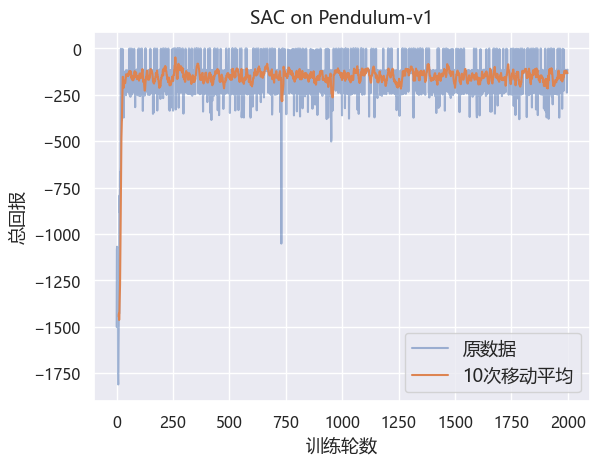

In [43]:
rl_utils.picture_return(return_list, 'SAC', env_name)

# 演示策略

平均回报:  -141.421


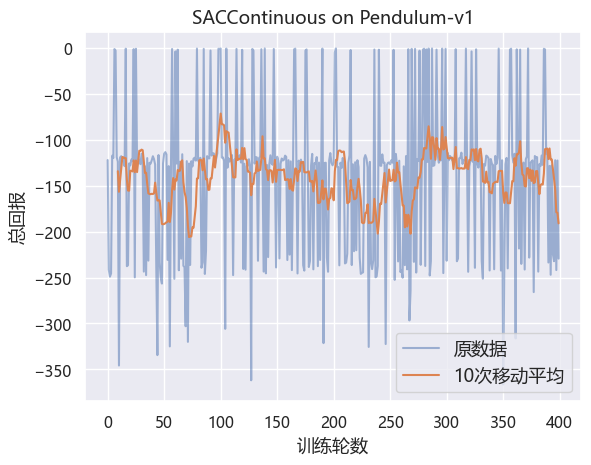

In [44]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'rgb_array', epochs=400, model_type='AC', if_return=True)

平均回报:  -108.089


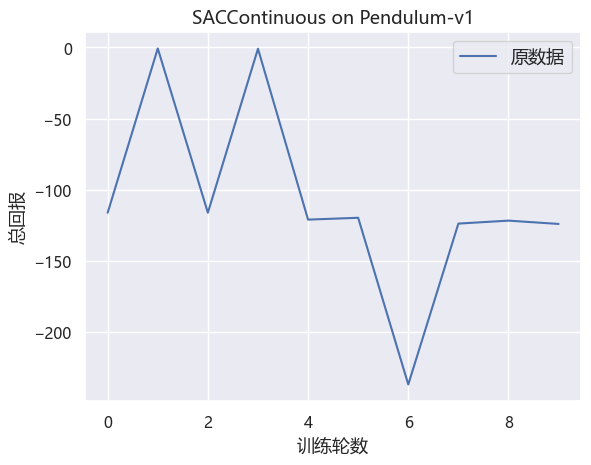

In [45]:
view_list = rl_utils.show_gym_policy(env_name, agent, 'human', epochs=10, model_type='AC', if_return=True)

# ✅SAC基本思想

基本思路是, 对网络输入状态, 网络给出动作和该动作的对数概率, 而把动作的对数概率取负就是熵, 熵越大, 代表该动作的不确定性越大, 也就是发生概率较小, 反过来, 熵越小, 说明确定性越大, SAC模型的目标就是希望策略的回报和熵都尽可能大，熵前面有一个$\alpha$调整熵的重要性, 也称为`温度`。
$$
\pi^* = \underset{\pi}{\operatorname{argmax}}\mathbb{E}_{\pi}\left[\underset{t}{\sum}r(s_t,a_t)+\alpha\mathcal{H}(\pi(\cdot|s_t)) \right]
$$
也可以写成总的训练目标
$$
J(\pi)=\sum^{T}_{t=0}\mathbb{E}_{(s_t,a_t)\sim\rho_\pi}[r(s_t,a_t)+\alpha\mathcal{H}(\pi(\cdot|s_t))]
$$

其中熵就是对数化的动作概率加负号, 在代码里面表现为变量`entropy`

$$
\mathcal{H}(\pi(\cdot|s_t)) = -\log(\pi(a|s))
$$

并且V函数也加入熵, 如果不考虑负号应该是加上$\alpha\mathcal{H}(\pi(\cdot|s_t))$, 改写为$V^\pi_{soft}(s)$
$$
V^\pi_{soft}(s^\prime)=\mathbb{E}_{(s^\prime,a^\prime)\sim\rho_\pi}[Q_{soft}(s^\prime,a^\prime)-\alpha\log(\pi(a^\prime|s^\prime))]
$$

因此Q函数的贝尔曼方程跟以前类似 
$$
\begin{align}
Q^\pi_{soft}(s,a) 
& = r(s,a)+\gamma\mathbb{E}_{(s^\prime,a^\prime)\sim\rho_\pi}[Q(s^\prime,a^\prime)-\alpha\log(\pi(a^\prime|s^\prime))]\\

& = r(s,a)+\gamma\mathbb{E}_{s^\prime\sim\rho}[V^\pi_{soft}(s^\prime)]
\end{align}
$$


😯 $Q_{soft}$的**目标函数**, 对应代码`SAC`类中的`calc_target`方法, 公式为
$$
\begin{align}
J_Q(\theta) &= \mathbb{E}_{(s_t,a_t,s_{t+1})\sim \mathcal{D}}\left[\frac{1}{2}(Q_\theta(s_t,a_t)-(r(s_t,a_t)+\gamma V_{\bar{\theta}}(s_{t+1})))^2\right] \\
&=\mathbb{E}_{(s_t,a_t,s_{t+1})\sim \mathcal{D}}\left[\frac{1}{2}(Q_\theta(s_t,a_t)-(r(s_t,a_t)+\gamma (Q_{\bar \theta}(s_{t+1},a_{t+1})-
\alpha\log(\pi(a_{t+1}|s_{t+1})))^2\right]
\end{align}
$$

其中$Q_{\bar \theta}$是两个评论员网络给出的价值评价的较小的那个，这里对$\theta$求梯度是很简单的。

😯 $V_{soft}$, 即策略网络Policy的**目标函数**为

$$
\begin{align}
J_\pi(\phi)
&= D_{KL}\left(\pi_k(\cdot|s_t)||\frac{exp(\frac{1}{\alpha}Q^\pi_{soft}(s_t,\cdot))}{Z_{soft}^\pi(s_t)}\right)\\
&= \mathbb{E}_{s_t\sim\mathcal{D},a\sim\pi_\phi}\left[\log\pi_\phi(a_t|s_t)-\frac{1}{\alpha}Q_{\bar \theta}(s_t,a_t)+\log Z(s_t)\right]
\end{align}
$$
其中KL散度公式：
$$
\begin{align}
D_{KL}(P||Q) &= \int_x p(x)\operatorname{log}\frac{P(x)}{Q(x)}\operatorname{d}x \\
&= \mathbb{E}\left[\operatorname{log}\frac{P(x)}{Q(x)} \right]

\end{align}
$$

由于求梯度时也不需要对$Z$求梯度，而且本来也不知道$Z$，所以代码里面去掉了， [原论文](https://arxiv.org/pdf/1801.01290.pdf)思想也就是这样，位于第四页右侧上面，代码里面还全部同时乘以了$\alpha$，这里就不乘了，直接写为

$$
J_\pi(\phi) = \mathbb{E}_{s_t\sim\mathcal{D},a\sim\pi_\phi}\left[\log\pi_\phi(a_t|s_t)-\frac{1}{\alpha}Q_{\bar \theta}(s_t,a_t)\right]
$$

这个目标函数是KL散度，表示两个分布之间的差异程度，减小这个目标函数就是试图使策略函数$\pi_k$的分布看起来更像是由函数Z标准化的Q函数的指数分布；其中$a_t$是重参数化来的，目的是让梯度正常更新，$\epsilon$是从高斯分布采样的噪音。对策略目标函数的参数$\phi$求导时，与$Z$无关，但是与Q有关，因为Q中的$a_t$是从策略中重参数化取得的，如下面公式

$$
a_t=f_\phi(\epsilon_t;s_t)=f^\mu_\phi(s_t)+\epsilon_t\cdot f^\mu_\phi(s_t)
$$
在求熵的时候，动作$u$原本是从正态分布采样的，但是经过$a=\operatorname{tanh}(u)$压缩处理，不再是正态分布，需要重新计算概率，需要注意的是，这里采样到的单个动作的概率就是概率密度，而不是概率分布，这里的$\pi$和$\mu$都是概率密度函数，推导如下

$$
\begin{align}
a &= \operatorname{tanh}(u) \\
\pi(a|s)\operatorname{d}a&=\mu(u|s)\operatorname{d}u\\
\pi(a|s) 
&= \mu(u|s)(\frac{\operatorname{d}a}{\operatorname{d}u})^{-1}\\
其中:\frac{\operatorname{d}a}{\operatorname{d}u} &= 1-\operatorname{tanh}^2u \\
\pi(a|s) &= \mu(u|s)(1-\operatorname{tanh}^2u)^{-1} \\
两边加对数:\operatorname{log}\pi(a|s) 
&= \operatorname{log}\mu(u|s)-\sum^D_{i=1}\operatorname{log}(1-\operatorname{tanh}^2(u_i)) \\
&= \operatorname{log}\mu(u|s)-\sum^D_{i=1}\operatorname{log}(1-a_i^2)
\end{align}
$$


😯 $\alpha$也是要调整的, 存在以下约束优化, 其中$\mathcal{H}_0$是可以调整的参数。

$$
\underset{\pi}{\operatorname{max}} \mathbb{E}\left[\underset{t}{\sum}r(s_t, a_t) \right] ~~~~ \operatorname{s.t.} ~~~~ \mathbb{E}_{(s_t,a_t)\sim\rho_\pi} \left[-\operatorname{log}(\pi(a_t|s_t)) \right] \geq \mathcal{H}_0
$$

约束优化问题中没有$\alpha$，它是作为拉格朗日乘子出现的，需要转化为对偶问题，参考[第十三章 SAC 算法](https://johnjim0816.com/joyrl-book/#/ch13/main?id=%e8%87%aa%e5%8a%a8%e8%b0%83%e8%8a%82%e6%b8%a9%e5%ba%a6%e5%9b%a0%e5%ad%90)，未完全理解，解出其目标函数为 #问题
$$

\begin{align}

J(\alpha)

&= \mathbb{E}_{a_t\sim\pi_t}\left[-\alpha \log \pi_t(a_t|s_t)-\alpha\mathcal{H}_0\right] \\

&= \mathbb{E}_{a_t\sim\pi_t}\left[\alpha(-\log \pi_t(a_t|s_t)-\mathcal{H}_0)\right]

\end{align}

$$
其中$-\log \pi_t(a_t|\pi_t)$也就是熵`entropy`，对$\alpha$求导，就等于小括号里面的动作熵减去目标熵，所以这就是要使得动作熵靠近目标熵，使得$J(\alpha)$变小。

参考下面策略目标函数，动作熵太大，大于目标熵了，梯度就是正的，$\alpha$目标函数在梯度下降时就会减小$\alpha$，就是指策略给的动作的概率比较低，拿不准应该怎么办，需要减小$\alpha$使得模型专注于获得更高的回报，也就是尽可能提升动作确定性；而动作熵太小，就意味着策略对某一个动作过于肯定，容易造成过拟合，就调整$\alpha$变大，$\alpha$变大就倾向于要求动作熵变大，等于希望动作概率降低，让模型重视探索。

$$
\pi^* = \underset{\pi}{\operatorname{argmax}}\mathbb{E}_{\pi}\left[\underset{t}{\sum}r(s_t,a_t)+\alpha\mathcal{H}(\pi(\cdot|s_t)) \right]
$$
## 目标熵 

 [原论文](https://arxiv.org/pdf/1801.01290.pdf)认为连续动作的目标熵等于动作空间的负值，torchrl中默认为`torch.prod(n_actions)`，另一篇[论文](https://arxiv.org/pdf/1910.07207.pdf)给出离散SAC，目标熵设置为$0.98(-\operatorname{log}(\frac{1}{|A|}))$，依据未说明，可能和交叉熵类似，但是总的来说不建议将SAC应用于离散动作环境。

# SAC离散动作

In [11]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import rl_utils
import os

## 网络

In [12]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)  # 直接输出softmax


class QValueNet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## SAC

In [26]:
class SAC:
    ''' 处理离散动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 alpha_lr, target_entropy, tau, gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 第一个Q网络
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 第二个Q网络
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device).unsqueeze(0)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    # 计算目标Q值,直接用策略网络的输出概率进行期望计算
    def calc_target(self, rewards, next_states, dones, truncated):
        next_probs = self.actor(next_states)
        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)
        q1_value = self.target_critic_1(next_states)
        q2_value = self.target_critic_2(next_states)
        min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones | truncated)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        # 动作不再是float类型, 建议强制int64
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)  
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones, truncated)
        critic_1_q_values = self.critic_1(states).gather(1, actions)
        critic_1_loss = torch.mean(F.mse_loss(critic_1_q_values, td_target.detach()))
        critic_2_q_values = self.critic_2(states).gather(1, actions)
        critic_2_loss = torch.mean(F.mse_loss(critic_2_q_values, td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        # 直接根据概率计算熵
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)
        q1_value = self.critic_1(states)
        q2_value = self.critic_2(states)
        min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)  # 直接根据概率计算期望
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

## 超参数

In [27]:
# 环境相关
env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# SAC算法相关
PATH = 'checkpoints/SAC_CPv1.pt'
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
total_epochs = 6
total_episodes = 200
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = 0.98 * (-np.log(1 / env.action_space.n))  # 离散动作目标熵, 离散SAC论文给的目标熵是0.98(-log(1/|A|))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n

# 无需输入动作上限, 现在动作是离散的
agent = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr,
            target_entropy, tau, gamma, device)

cuda


## 读取检查点

In [31]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic_1.load_state_dict(checkpoint['critic_1_best_weight'])
        agent.critic_2.load_state_dict(checkpoint['critic_2_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

In [32]:
s_epoch, s_episode, return_list = read_ckp(PATH)

## 训练

In [33]:
return_list = rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, 
                                              s_episode, total_episodes, 
                                              replay_buffer, minimal_size, batch_size, 
                                              return_list, PATH, 3)

总耗时: 6分钟


# 作图

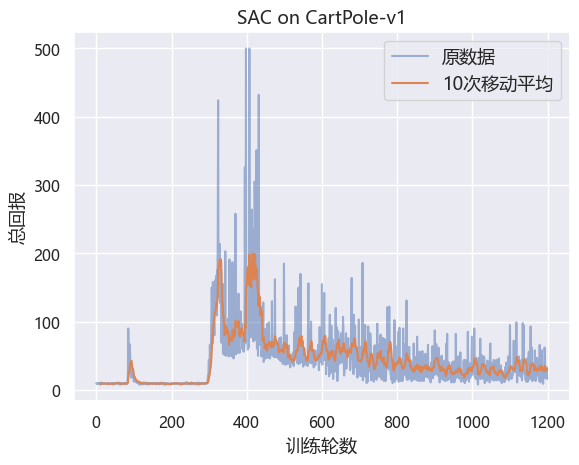

In [34]:
s_epoch, s_episode, return_list = read_ckp(PATH)
rl_utils.picture_return(return_list, 'SAC', env_name)

# 演示策略

平均回报:  119.75


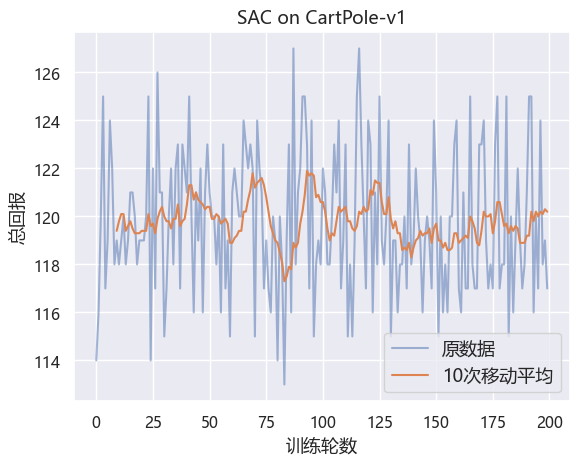

In [69]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'rgb_array', epochs=200, model_type='AC', if_return=True)

In [70]:
rl_utils.show_gym_policy(env_name, agent, 'human', epochs=10, model_type='AC')

平均回报:  121.2


[126.0, 124.0, 120.0, 122.0, 118.0, 116.0, 119.0, 124.0, 125.0, 118.0]